In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [ ]:
dataset = pd.read_csv('cleaned_datasets/endogenous_warszawa.csv')
print(dataset.head())
print(dataset.shape)

for col in dataset.select_dtypes(include=['float64', 'int64']).columns:
   dataset[col] = dataset[col].round(0).astype('int64')

dtypes = dataset.dtypes

for col in dataset.columns:
   unique_values = dataset[col].nunique()
   
   if unique_values < 5:
       value_counts = dataset[col].value_counts(normalize=True) * 100
       for value, percentage in value_counts.items():
           print(f"{col} {value}: {percentage:.2f}%")
   else:
       p01 = dataset[col].quantile(0.01)
       p99 = dataset[col].quantile(0.99)
       print(f"{col} 0.01: {p01}")
       print(f"{col} 0.99: {p99}")


    pricePerSqm  rooms buildingMaterial          type  buildYear hasElevator  \
0  15000.000000    3.0            brick  blockOfFlats     2009.0          no   
1  17919.480519    2.0     concreteSlab  blockOfFlats     1973.0         yes   
2  22916.666667    4.0            brick  blockOfFlats     2022.0         yes   
3  25201.008040    4.0            brick      tenement     1937.0         yes   
4  19950.000000    2.0            brick  blockOfFlats     2018.0         yes   

  hasBalcony  condition hasParkingSpace  squareMeters hasSecurity  floorCount  \
0        yes  not known             yes         85.00         yes         3.0   
1        yes  not known              no         38.50          no        10.0   
2        yes  not known             yes         96.00          no         4.0   
3        yes        low              no         83.33          no         4.0   
4         no  not known              no         44.94         yes         8.0   

   floor hasStorageRoom  
0    1

In [3]:
p01_price = dataset['pricePerSqm'].quantile(0.02)
p99_price = dataset['pricePerSqm'].quantile(0.98)
p99_sqm = dataset['squareMeters'].quantile(0.98)

dataset = dataset[(dataset['pricePerSqm'] >= p01_price) & 
                 (dataset['pricePerSqm'] <= p99_price) & 
                 (dataset['squareMeters'] <= p99_sqm)]
dataset.shape

(24380, 14)

In [21]:



X = dataset.iloc[:, 2:]
y = dataset.iloc[:, 1]

encoders = {}
categorical_cols = ['buildingMaterial', 'type', 'hasElevator', 'hasBalcony', 
                  'condition', 'hasParkingSpace', 'hasSecurity', 'hasStorageRoom']
for col in categorical_cols:
   encoders[col] = LabelEncoder()
   X[col] = encoders[col].fit_transform(X[col])
   
for col in categorical_cols:
   mapping_encoders = dict(zip(encoders[col].classes_, encoders[col].transform(encoders[col].classes_)))
   print(f"{col}: {mapping_encoders}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2137)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1488)

buildingMaterial: {'brick': np.int64(0), 'concreteSlab': np.int64(1)}
type: {'apartmentBuilding': np.int64(0), 'blockOfFlats': np.int64(1), 'tenement': np.int64(2)}
hasElevator: {'no': np.int64(0), 'yes': np.int64(1)}
hasBalcony: {'no': np.int64(0), 'yes': np.int64(1)}
condition: {'low': np.int64(0), 'not known': np.int64(1), 'premium': np.int64(2)}
hasParkingSpace: {'no': np.int64(0), 'yes': np.int64(1)}
hasSecurity: {'no': np.int64(0), 'yes': np.int64(1)}
hasStorageRoom: {'no': np.int64(0), 'yes': np.int64(1)}


In [27]:
space = {
    'max_depth': hp.quniform("max_depth", 3, 15, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.quniform('n_estimators', 100, 500, 10),
    'subsample': hp.uniform('subsample', 0.5, 1)
}

def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': params['gamma'],
        'reg_alpha': int(params['reg_alpha']),
        'reg_lambda': params['reg_lambda'],
        'colsample_bytree': params['colsample_bytree'],
        'min_child_weight': int(params['min_child_weight']),
        'learning_rate': params['learning_rate'],
        'n_estimators': int(params['n_estimators']),
        'subsample': params['subsample'],
        'random_state': 2137
    }
    
    model = XGBRegressor(**params)
    
    model.fit(X_train, y_train)
    
    pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, pred)
    print(f"MAE: {mae}")
    
    return {'loss': mae, 'status': STATUS_OK}

trials = Trials()

best_hyperparams = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=200,
    trials=trials
)

print(best_hyperparams)

MAE: 0.33198052644729614                                
MAE: 0.3120175898075104                                                            
MAE: 0.32514891028404236                                                           
MAE: 0.3236333131790161                                                           
MAE: 0.3140704035758972                                                           
MAE: 0.33739373087882996                                                          
MAE: 0.3404521048069                                                              
MAE: 0.3239331543445587                                                           
MAE: 0.32023587822914124                                                          
MAE: 0.3323209583759308                                                           
MAE: 0.3211205303668976                                                            
MAE: 0.32719162106513977                                                           
MAE: 0.32843002676963806  

In [28]:
best_params = {
    'max_depth': int(best_hyperparams['max_depth']),
    'gamma': best_hyperparams['gamma'],
    'reg_alpha': int(best_hyperparams['reg_alpha']),
    'reg_lambda': best_hyperparams['reg_lambda'],
    'colsample_bytree': best_hyperparams['colsample_bytree'],
    'min_child_weight': int(best_hyperparams['min_child_weight']),
    'learning_rate': best_hyperparams['learning_rate'],
    'n_estimators': int(best_hyperparams['n_estimators']),
    'subsample': best_hyperparams['subsample'],
    'random_state': 2137
}

final_model = XGBRegressor(**best_params)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

MAE: 0.3142472505569458
MAPE: 13.259662687778473%


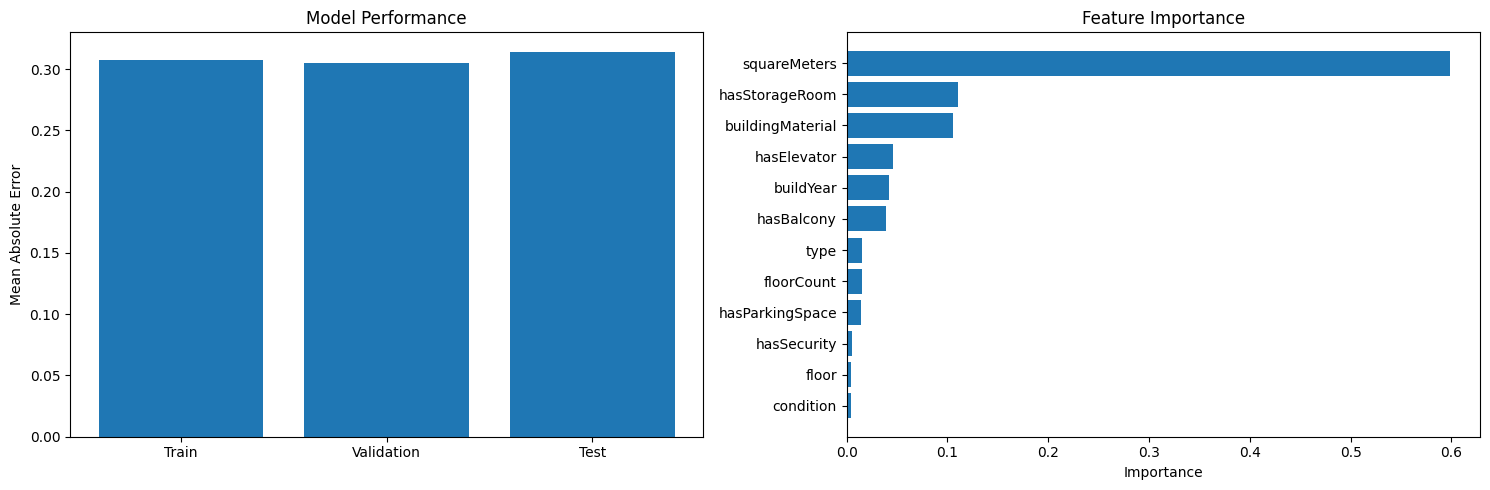

In [29]:
fig = plt.figure(figsize=(15,5))

# Plot model performance on different datasets
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Model Performance")
train_mae = mean_absolute_error(y_train, final_model.predict(X_train))
valid_mae = mean_absolute_error(y_valid, final_model.predict(X_valid))
test_mae = mae
datasets = ['Train', 'Validation', 'Test']
maes = [train_mae, valid_mae, test_mae]
ax.bar(datasets, maes)
ax.set_ylabel('Mean Absolute Error')

# Plot feature importance
ax = fig.add_subplot(1, 2, 2)
ax.set_title("Feature Importance")
feature_importance = final_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [32]:
X = dataset.iloc[:, 1:]  # All features except the price per square meter
y = dataset.iloc[:, 0]   # Price per square meter

# Encode categorical columns
encoders = {}
categorical_cols = ['buildingMaterial', 'type', 'hasElevator', 'hasBalcony', 
                   'condition', 'hasParkingSpace', 'hasSecurity', 'hasStorageRoom']

for col in categorical_cols:
    encoders[col] = LabelEncoder()
    X[col] = encoders[col].fit_transform(X[col])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2137)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1488)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['rooms', 'buildYear', 'squareMeters', 'floorCount', 'floor']
X_train_scaled = X_train.copy()
X_valid_scaled = X_valid.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_valid_scaled[numerical_cols] = scaler.transform(X_valid[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [34]:
space = {
    'units_layer1': hp.quniform('units_layer1', 10, 50, 5),
    'units_layer2': hp.quniform('units_layer2', 10, 50, 5),
    'units_layer3': hp.quniform('units_layer3', 10, 50, 5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
    'batch_size': hp.choice('batch_size', [4, 8, 16, 32, 64])
}

def objective(params):
    tf.random.set_seed(42042)
    
    model = Sequential()
    model.add(Dense(int(params['units_layer1']), activation='relu', input_dim=X_train_scaled.shape[1]))
    model.add(Dense(int(params['units_layer2']), activation='relu'))
    model.add(Dense(int(params['units_layer3']), activation='relu'))
    model.add(Dense(1))
    
    model.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='mean_absolute_percentage_error',
        metrics=['mae']
    )
    
    callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    batch_size = params['batch_size']
    
    model.fit(
        X_train_scaled, y_train,
        epochs=100, 
        batch_size=batch_size,
        validation_data=(X_valid_scaled, y_valid),
        callbacks=[callback],
        verbose=0
    )
    
    val_pred = model.predict(X_valid_scaled, verbose=0)
    val_mape = mean_absolute_percentage_error(y_valid, val_pred) * 100
    print(f"MAPE: {val_mape}%")
    
    return {'loss': val_mape, 'status': STATUS_OK}

trials = Trials()

best_hyperparams = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials
)

print(best_hyperparams)

MAPE: 14.232181012630463%                             
  5%|▌         | 1/20 [00:29<09:28, 29.90s/trial, best loss: 14.232181012630463]

/Users/staszek/Desktop/microdata_code/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MAPE: 14.05850499868393%                                                        
 10%|█         | 2/20 [01:58<19:19, 64.41s/trial, best loss: 14.05850499868393] 

/Users/staszek/Desktop/microdata_code/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MAPE: 14.78574275970459%                                                       
 15%|█▌        | 3/20 [04:51<32:17, 113.98s/trial, best loss: 14.05850499868393]

/Users/staszek/Desktop/microdata_code/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MAPE: 14.071820676326752%                                                       
 20%|██        | 4/20 [05:46<24:14, 90.89s/trial, best loss: 14.05850499868393] 

/Users/staszek/Desktop/microdata_code/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MAPE: 13.974401354789734%                                                      
 25%|██▌       | 5/20 [06:59<21:02, 84.18s/trial, best loss: 13.974401354789734]

/Users/staszek/Desktop/microdata_code/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MAPE: 14.276063442230225%                                                       
 30%|███       | 6/20 [08:26<19:51, 85.11s/trial, best loss: 13.974401354789734]

/Users/staszek/Desktop/microdata_code/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MAPE: 14.337489008903503%                                                       
 35%|███▌      | 7/20 [08:37<13:13, 61.03s/trial, best loss: 13.974401354789734]

/Users/staszek/Desktop/microdata_code/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MAPE: 14.189673960208893%                                                       
 40%|████      | 8/20 [10:00<13:37, 68.11s/trial, best loss: 13.974401354789734]

/Users/staszek/Desktop/microdata_code/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MAPE: 14.289022982120514%                                                       
 45%|████▌     | 9/20 [10:31<10:19, 56.30s/trial, best loss: 13.974401354789734]

/Users/staszek/Desktop/microdata_code/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MAPE: 14.44864571094513%                                                        
 50%|█████     | 10/20 [11:01<08:03, 48.33s/trial, best loss: 13.974401354789734]

/Users/staszek/Desktop/microdata_code/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MAPE: 14.07029777765274%                                                         
 55%|█████▌    | 11/20 [11:33<06:30, 43.34s/trial, best loss: 13.974401354789734]

/Users/staszek/Desktop/microdata_code/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MAPE: 14.145871996879578%                                                        
 60%|██████    | 12/20 [12:26<06:08, 46.07s/trial, best loss: 13.974401354789734]

/Users/staszek/Desktop/microdata_code/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MAPE: 14.239974319934845%                                                        
 65%|██████▌   | 13/20 [13:02<05:01, 43.11s/trial, best loss: 13.974401354789734]

/Users/staszek/Desktop/microdata_code/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MAPE: 14.157834649085999%                                                        
 70%|███████   | 14/20 [16:47<09:49, 98.22s/trial, best loss: 13.974401354789734]

/Users/staszek/Desktop/microdata_code/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MAPE: 14.096580445766449%                                                        
 75%|███████▌  | 15/20 [17:32<06:50, 82.16s/trial, best loss: 13.974401354789734]

/Users/staszek/Desktop/microdata_code/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MAPE: 14.055487513542175%                                                        
 80%|████████  | 16/20 [18:20<04:46, 71.68s/trial, best loss: 13.974401354789734]

/Users/staszek/Desktop/microdata_code/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MAPE: 14.247769117355347%                                                        
 85%|████████▌ | 17/20 [19:10<03:15, 65.12s/trial, best loss: 13.974401354789734]

/Users/staszek/Desktop/microdata_code/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MAPE: 14.265812933444977%                                                        
 90%|█████████ | 18/20 [19:43<01:51, 55.50s/trial, best loss: 13.974401354789734]

/Users/staszek/Desktop/microdata_code/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MAPE: 14.103975892066956%                                                        
 95%|█████████▌| 19/20 [21:20<01:08, 68.11s/trial, best loss: 13.974401354789734]

/Users/staszek/Desktop/microdata_code/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MAPE: 14.247649908065796%                                                        
100%|██████████| 20/20 [22:08<00:00, 66.42s/trial, best loss: 13.974401354789734]
{'batch_size': np.int64(0), 'learning_rate': np.float64(0.004776996222732781), 'units_layer1': np.float64(25.0), 'units_layer2': np.float64(35.0), 'units_layer3': np.float64(40.0)}


In [ ]:
best_params = {
    'units_layer1': int(best_hyperparams['units_layer1']),
    'units_layer2': int(best_hyperparams['units_layer2']),
    'units_layer3': int(best_hyperparams['units_layer3']),
    'learning_rate': best_hyperparams['learning_rate'],
    'batch_size': [4, 8, 16, 32, 64][best_hyperparams['batch_size']]
}

tf.random.set_seed(42042)

final_model = Sequential()
final_model.add(Dense(best_params['units_layer1'], activation='relu', input_dim=X_train_scaled.shape[1]))
final_model.add(Dense(best_params['units_layer2'], activation='relu'))
final_model.add(Dense(best_params['units_layer3'], activation='relu'))
final_model.add(Dense(1))

final_model.compile(
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    loss='mean_absolute_percentage_error',
    metrics=['mae']
)

callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = final_model.fit(
    X_train_scaled, y_train,
    epochs=500,
    batch_size=best_params['batch_size'],
    validation_data=(X_valid_scaled, y_valid),
    callbacks=[callback]
)

y_pred = final_model.predict(X_test_scaled)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
mae = mean_absolute_error(y_test, y_pred)

print(f"Final Model - Test MAPE: {mape}%")
print(f"Final Model - Test MAE: {mae}")

Epoch 1/500


/Users/staszek/Desktop/microdata_code/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4876/4876 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 24.5152 - mae: 4353.7798 - val_loss: 14.6079 - val_mae: 2543.8813
Epoch 2/500
4876/4876 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 14.8778 - mae: 2663.5159 - val_loss: 14.7228 - val_mae: 2531.2339
Epoch 3/500
4876/4876 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 14.7341 - mae: 2638.4568 - val_loss: 14.5145 - val_mae: 2510.9404
Epoch 4/500
4876/4876 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 14.6847 - mae: 2626.9556 - val_loss: 14.5033 - val_mae: 2515.3743
Epoch 5/500
4876/4876 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 14.6566 - mae: 2623.8555 - val_loss: 14.5181 - val_mae: 2508.3589
Epoch 6/500
4876/4876 ━━━━━━━━━━━━━━━━━━━━ 5s 973us/step - loss: 14.6344 - mae: 2618.5408 - val_loss: 14.4170 - val_mae: 2500.6418
Epoch 7/500
4876/4876 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 14.6066 - mae: 2610.6543 - val_loss: 14.4864 - val_mae: 2512.9463
Epoch 8/500
4876/4876 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 14.5990 - mae: 2607.9026 - val_loss: 14.4735

In [ ]:
fig = plt.figure(figsize=(15,5))

# Plot learning curves
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Mean Absolute Percentage Error")
ax.plot(history.history['loss'], label='train data')
ax.plot(history.history['val_loss'], label='validation data')
ax.set_ylim(top=15)
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.set_title("Mean Absolute Error")
ax.plot(history.history['mae'], label='train data')
ax.plot(history.history['val_mae'], label='validation data')
ax.set_ylim(top=5000)
ax.legend()
plt.show()

# Error distribution analysis
test_pred = final_model.predict(X_test_scaled)
test_results = X_test.copy()
test_results['y_test'] = y_test
test_results['y_pred'] = test_pred
test_results['error'] = 100*(test_results['y_pred'] - test_results['y_test'])/test_results['y_test']
test_results['abs_error'] = abs(test_results['error'])

quantiles = test_results['error'].quantile([0.25, 0.5, 0.75])

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Error Percentage Distribution")
ax.hist(test_results['error'], bins=100)
ax.axvline(quantiles[0.25], color='k', linestyle='dashed', linewidth=1)
ax.axvline(quantiles[0.5], color='k', linestyle='solid', linewidth=1)
ax.axvline(quantiles[0.75], color='k', linestyle='dashed', linewidth=1)
ax.yaxis.set_visible(False)

ax = fig.add_subplot(1, 2, 2)
ax.set_title("Error Percentage Distribution")
ax.boxplot([test_results['error']], showfliers=False, vert=False)
ax.set_xlim(-50, 50)
ax.grid(linewidth=1, color="#ccc", which='major')
ax.yaxis.set_visible(False)

plt.show()

error_stats = pd.DataFrame(test_results['error'].quantile([0.25, 0.5, 0.75])).reset_index()
error_stats.columns = ['percentile', 'error']
error_stats['percentile'] = error_stats['percentile'] * 100
error_stats['percentile'] = error_stats['percentile'].astype(int)
error_stats['error'] = round(error_stats['error']*10)/10
print(error_stats)